In [32]:
import warnings
import glob
import math
from os.path import join
from datetime import time, datetime

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage.draw import polygon
import SimpleITK as sitk
import pydicom as pdcm
from pydicom.tag import Tag

from viz_utils import NdimageVisualizer

## RTstruct-to-mask conversion utils

Taken from HECKTOR repo

In [33]:
def get_masks(rtstruct_file,
              labels=['GTVp1', 'BODY'],
              image_position_patient=None,
              axial_positions=None,
              pixel_spacing=None,
              shape=None,
              dtype=np.int8):
    contours = read_structure(rtstruct_file, labels=labels)
    return get_mask_from_contour(contours,
                                 image_position_patient,
                                 axial_positions,
                                 pixel_spacing,
                                 shape,
                                 dtype=dtype)


def read_structure(rtstruct_file, labels=['GTVp1', 'BODY']):
    structure = pdcm.read_file(rtstruct_file)
    contours = []
    for i, roi_seq in enumerate(structure.StructureSetROISequence):
        contour = {}
        for label in labels:
            if roi_seq.ROIName == label:
                contour['color'] = structure.ROIContourSequence[
                    i].ROIDisplayColor
                contour['number'] = structure.ROIContourSequence[
                    i].ReferencedROINumber
                contour['name'] = roi_seq.ROIName
                assert contour['number'] == roi_seq.ROINumber
                contour['contours'] = [
                    s.ContourData
                    for s in structure.ROIContourSequence[i].ContourSequence
                ]
                contours.append(contour)

    return contours


def get_mask_from_contour(contours,
                          image_position_patient,
                          axial_positions,
                          pixel_spacing,
                          shape,
                          dtype=np.uint8):
    z = np.asarray(axial_positions)
    pos_r = image_position_patient[1]
    spacing_r = pixel_spacing[1]
    pos_c = image_position_patient[0]
    spacing_c = pixel_spacing[0]

    output = {}
    for con in contours:
        mask = np.zeros(shape, dtype=dtype)
        for current in con['contours']:
            nodes = np.array(current).reshape((-1, 3))
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = np.where((nodes[0, 2] - 0.001 < z)
                               & (z < nodes[0, 2] + 0.001))[0][0]
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            if len(rr) > 0 and len(cc) > 0:
                if np.max(rr) > 512 or np.max(cc) > 512:
                    raise Exception("The RTSTRUCT file is compromised")

            mask[rr, cc, z_index] = 1
        output[con['name']] = mask
    return output


def get_physical_values_ct(slices, dtype=np.float32):
    image = list()
    for s in slices:
        image.append(
            float(s.RescaleSlope) * s.pixel_array + float(s.RescaleIntercept))
    return np.stack(image, axis=-1).astype(dtype)

## Config

In [34]:
DATA_ROOT_DIR = "/home/chinmay/Datasets/HX4-PET-Translation/Original"
SAMPLE_PATIENT = "N010"

## Read pCT and RTstruct,  convert RTstruct to masks

In [45]:
# Read pCT slices
dicom_filepaths = sorted(glob.glob(f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/FDG/CT/*"))
pct_slices = [pdcm.read_file(dcm) for dcm in dicom_filepaths]
pct_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Get additional image details
slice_spacing = pct_slices[1].ImagePositionPatient[2] - pct_slices[0].ImagePositionPatient[2]
pixel_spacing = np.asarray([pct_slices[0].PixelSpacing[0], pct_slices[0].PixelSpacing[1], slice_spacing])
image_position_patient = [float(k) for k in pct_slices[0].ImagePositionPatient]

axial_positions = np.asarray([k.ImagePositionPatient[2] for k in pct_slices])

# Convert pCT to numpy
pct_np = get_physical_values_ct(pct_slices, dtype=np.float32)

# Read RTstruct and get masks 
rtstruct_file = glob.glob(f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/FDG/RTSTRUCT/*")[0]
masks = get_masks(rtstruct_file,
                  labels=['GTVp1', 'BODY'],
                  image_position_patient=image_position_patient,
                  axial_positions=axial_positions,
                  pixel_spacing=pixel_spacing,
                  shape=pct_np.shape,
                  dtype=np.int8)

body_mask = masks['BODY']
gtv_mask = masks['GTVp1']

# HWD to WHD
pct_np = pct_np.transpose(1,0,2)
body_mask = body_mask.transpose(1,0,2)
gtv_mask = gtv_mask.transpose(1,0,2)

(1, 1, 3)


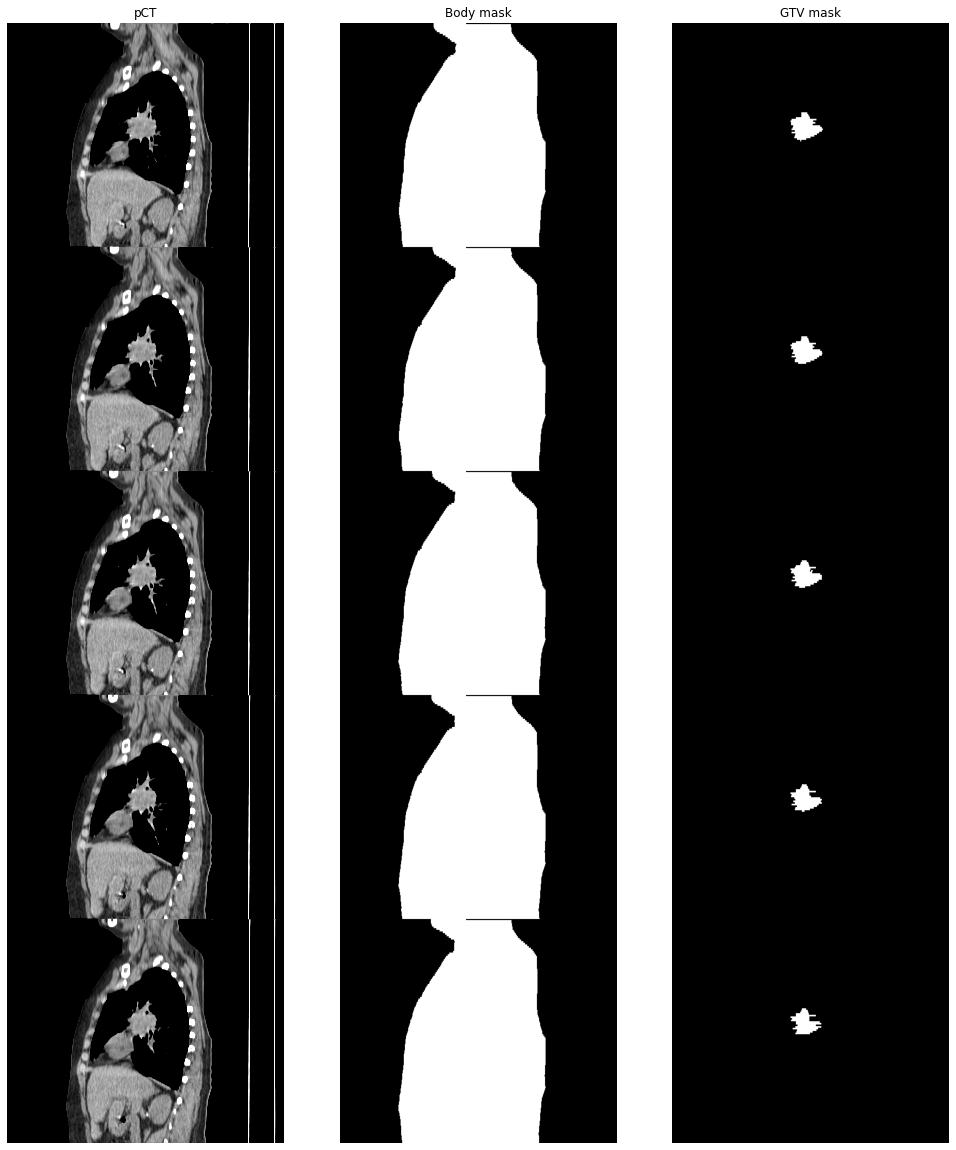

In [46]:
visualizer = NdimageVisualizer()

slice_spacing = pct_slices[1].ImagePositionPatient[2] - pct_slices[0].ImagePositionPatient[2]
spacing = (round(pct_slices[0].PixelSpacing[0]), round(pct_slices[0].PixelSpacing[1]), round(slice_spacing))
visualizer.set_spacing(spacing)
print(spacing)

visualizer.multi_image_strips([pct_np, body_mask, gtv_mask], 
                              image_types=['CT', 'labelmap', 'labelmap'], 
                              idx_range=[230, 235], 
                              view='sagittal',
                              subtitles=['pCT', 'Body mask', 'GTV mask'])